In [1]:
from functions import *
from model import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
config = ModelConfig()
model = EvalModel(config)
dataset = EvaluationDataset(config.data_count)
data_iter = iter(dataset)
model.load_state_dict(torch.load('model.pth', device))
model.eval()
params = model.state_dict()
l1_w = params['l1.weight'].cpu()
l1_b = params['l1.bias'].cpu()
l2_w = params['l2.weight'].cpu()
l2_b = params['l2.bias'].cpu()
relu_basis = torch.eye(8)

# torch.matmul(U, S.reshape(8, 1) * Vh) <= this produces the original l1_w
U, S, Vt = torch.linalg.svd(l1_w, full_matrices=False)
l1_w_inv = torch.linalg.pinv(l1_w)
V, St, Ut = torch.linalg.svd(l1_w_inv, full_matrices=False)

# input_basis = torch.matmul(l1_w_inv, relu_basis - l1_b.reshape(8, 1))
input_basis = torch.matmul(l1_w_inv, relu_basis)
input_onbasis = gs(input_basis)
on_proj_mat = torch.matmul(input_onbasis.T, torch.eye(768))
proj_mat = change_of_basis(on_proj_mat, input_onbasis, input_basis)

# sanity check of projection matrix
torch.isclose(torch.matmul(l1_w, torch.eye(768)), 
              torch.matmul(l1_w, torch.matmul(input_basis, proj_mat)), 
              atol=1e-4).all()

tensor(True)

In [6]:
print("l1_b: ", l1_b)
print("l2_w: ", l2_w)
print("l2_b: ", l2_b)

############# remark
# bad features for white: 5 > 3 > 8 > 2 > 6
# good features for white: 4 > 7 > 1

l1_b:  tensor([0.3936, 0.3148, 0.4401, 0.4770, 0.3741, 0.3278, 0.3766, 0.2999])
l2_w:  tensor([[ 2.4444, -1.9619, -2.3068,  3.1478, -2.7552, -1.8665,  2.7767, -2.1638]])
l2_b:  tensor([0.6826])


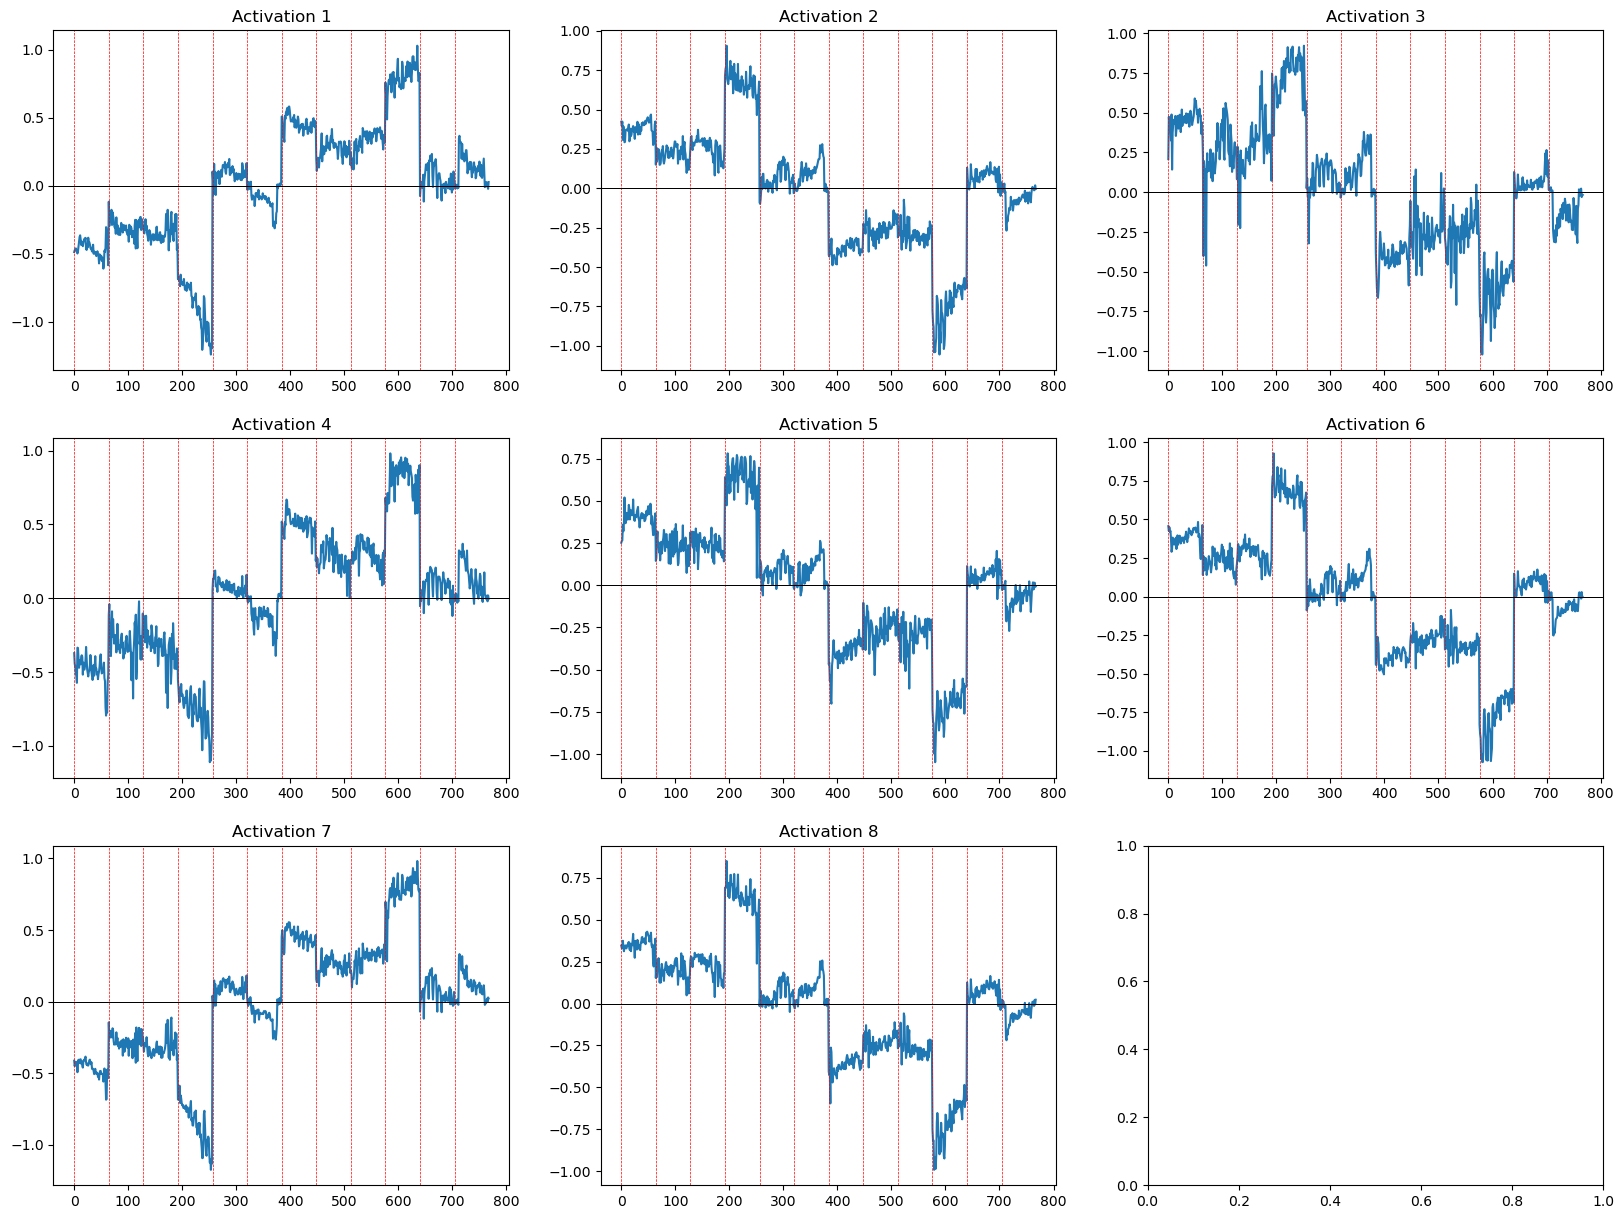

In [536]:
activation = torch.matmul(l1_w, torch.eye(768))
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for k in range(8):
    act = activation[k]
    ax[k//3][k%3].plot(arrange_to_piece(act.reshape(1,768)).reshape(768))
    for i in range(0, 768, 64):
        ax[k//3][k%3].axvline(i, color='r', linestyle='--', linewidth=0.5)
        ax[k//3][k%3].axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax[k//3][k%3].set_title("Activation {}".format(k + 1))
plt.show()

In [238]:
np.corrcoef(activation.numpy()).round(3)

array([[ 1.   , -0.957, -0.919,  0.969, -0.944, -0.958,  0.996, -0.954],
       [-0.957,  1.   ,  0.934, -0.942,  0.976,  0.998, -0.954,  0.997],
       [-0.919,  0.934,  1.   , -0.938,  0.951,  0.93 , -0.917,  0.931],
       [ 0.969, -0.942, -0.938,  1.   , -0.941, -0.942,  0.973, -0.938],
       [-0.944,  0.976,  0.951, -0.941,  1.   ,  0.973, -0.943,  0.978],
       [-0.958,  0.998,  0.93 , -0.942,  0.973,  1.   , -0.954,  0.996],
       [ 0.996, -0.954, -0.917,  0.973, -0.943, -0.954,  1.   , -0.952],
       [-0.954,  0.997,  0.931, -0.938,  0.978,  0.996, -0.952,  1.   ]])

In [137]:
abs_sum = arrange_to_piece(torch.mean(torch.abs(activation), dim=0).reshape(1, 768))

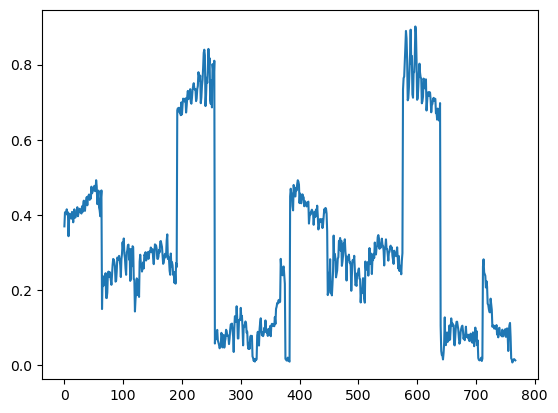

In [138]:
plt.plot(abs_sum.flatten())

In [281]:
piece_values = {}
for key, val in PIECES.items():
    piece_values[key] = np.mean(abs_sum[:,[val * 64 + i for i in range(64)]])
piece_values

{'r': 0.4239344224333763,
 'n': 0.251326838741079,
 'b': 0.286353018367663,
 'q': 0.7331176269799471,
 'k': 0.08570534462342039,
 'p': 0.10354232163808774,
 'R': 0.42236870946362615,
 'N': 0.2562676863744855,
 'B': 0.2946764084044844,
 'Q': 0.7465977715328336,
 'K': 0.07822035683784634,
 'P': 0.09816859422426205}

In [273]:
def algo(fen):
    piece_values = {
        'r': -0.4239344224333763,
        'n': -0.251326838741079,
        'b': -0.286353018367663,
        'q': -0.7331176269799471,
        'k': -0.08570534462342039,
        'p': -0.10354232163808774,
        'R': 0.42236870946362615,
        'N': 0.2562676863744855,
        'B': 0.2946764084044844,
        'Q': 0.7465977715328336,
        'K': 0.07822035683784634,
        'P': 0.09816859422426205
    }
    value = 0
    for p in fen:
        value += piece_values.get(p, 0)
    value = torch.tensor([value] * 8)
    for i in [1, 2, 4, 5, 7]:
        value[i] = -value[i]
    value += l1_b
    value = nn.ReLU()(value)
    value = torch.matmul(l2_w, value)
    value += l2_b
    return value

In [88]:
from sklearn.linear_model import LinearRegression

score = []
fen = []
for _ in range(10000):
    data = next(data_iter)
    score.append(data['score'])
    fen.append(data['fen'])

regression_model = LinearRegression()
regression_model.fit(fen, score)

# To make predictions using the regression model
# predictions = regression_model.predict(X)


LinearRegression()

In [89]:
diff = []
for _ in range(10000):
    data = next(data_iter)
    diff.append(torch.abs(model(torch.tensor(data['fen'])) - torch.tensor(regression_model.predict([data['fen']]))))
rms = torch.square(torch.tensor(diff)).mean()**0.5
print(rms)

tensor(2195.5994)


In [87]:
data = next(data_iter)
print(regression_model.predict([data['fen']]))
print(model(torch.tensor(data['fen'])))

[[-0.10906982]]
tensor([0.0463], grad_fn=<ViewBackward0>)


In [531]:
def algo2(fen):
    piece_values = {
        'r': -0.4239344224333763,
        'n': -0.251326838741079,
        'b': -0.286353018367663,
        'q': -0.7331176269799471,
        'k': -0.08570534462342039,
        'p': -0.10354232163808774,
        'R': 0.42236870946362615,
        'N': 0.2562676863744855,
        'B': 0.2946764084044844,
        'Q': 0.7465977715328336,
        'K': 0.07822035683784634,
        'P': 0.09816859422426205
    }
    value = 0
    for p in fen:
        value += piece_values.get(p, 0)
    return value * 10.3

In [268]:
data = next(data_iter)
id = data['id']
fen = Evaluations.get(Evaluations.id == id).fen.split()[0]
print(model(torch.tensor(data['fen'])))
print(algo(fen))

tensor([-2.1955], grad_fn=<ViewBackward0>)
tensor([-5.9691])


In [535]:
diff = []
for i in range(1000):
    data = next(data_iter)
    id = data['id']
    fen = Evaluations.get(Evaluations.id == id).fen.split()[0]
    diff.append(torch.abs(model(torch.tensor(data['fen'])) - algo(fen)))
rms = torch.square(torch.tensor(diff)).mean()**0.5
print(rms)

tensor(1.8686)


In [528]:
lamba = np.arange(0, 20, 0.1)
lambda_dict = {}
for i in lamba:
    diff = []
    for k in range(500):
        data = next(data_iter)
        id = data['id']
        fen = Evaluations.get(Evaluations.id == id).fen.split()[0]
        diff.append(torch.abs(model(torch.tensor(data['fen'])) - algo2(fen)))
    rms = torch.square(torch.tensor(diff)).mean()**0.5
    lambda_dict[i] = rms


In [279]:
diff = []
for i in range(10000):
    data = next(data_iter)
    id = data['id']
    fen = Evaluations.get(Evaluations.id == id).fen.split()[0]
    diff.append(torch.abs(model(torch.tensor(data['fen'])) - algo2(fen)))
rms = torch.square(torch.tensor(diff)).mean()**0.5
print(rms)

tensor(1.9369)


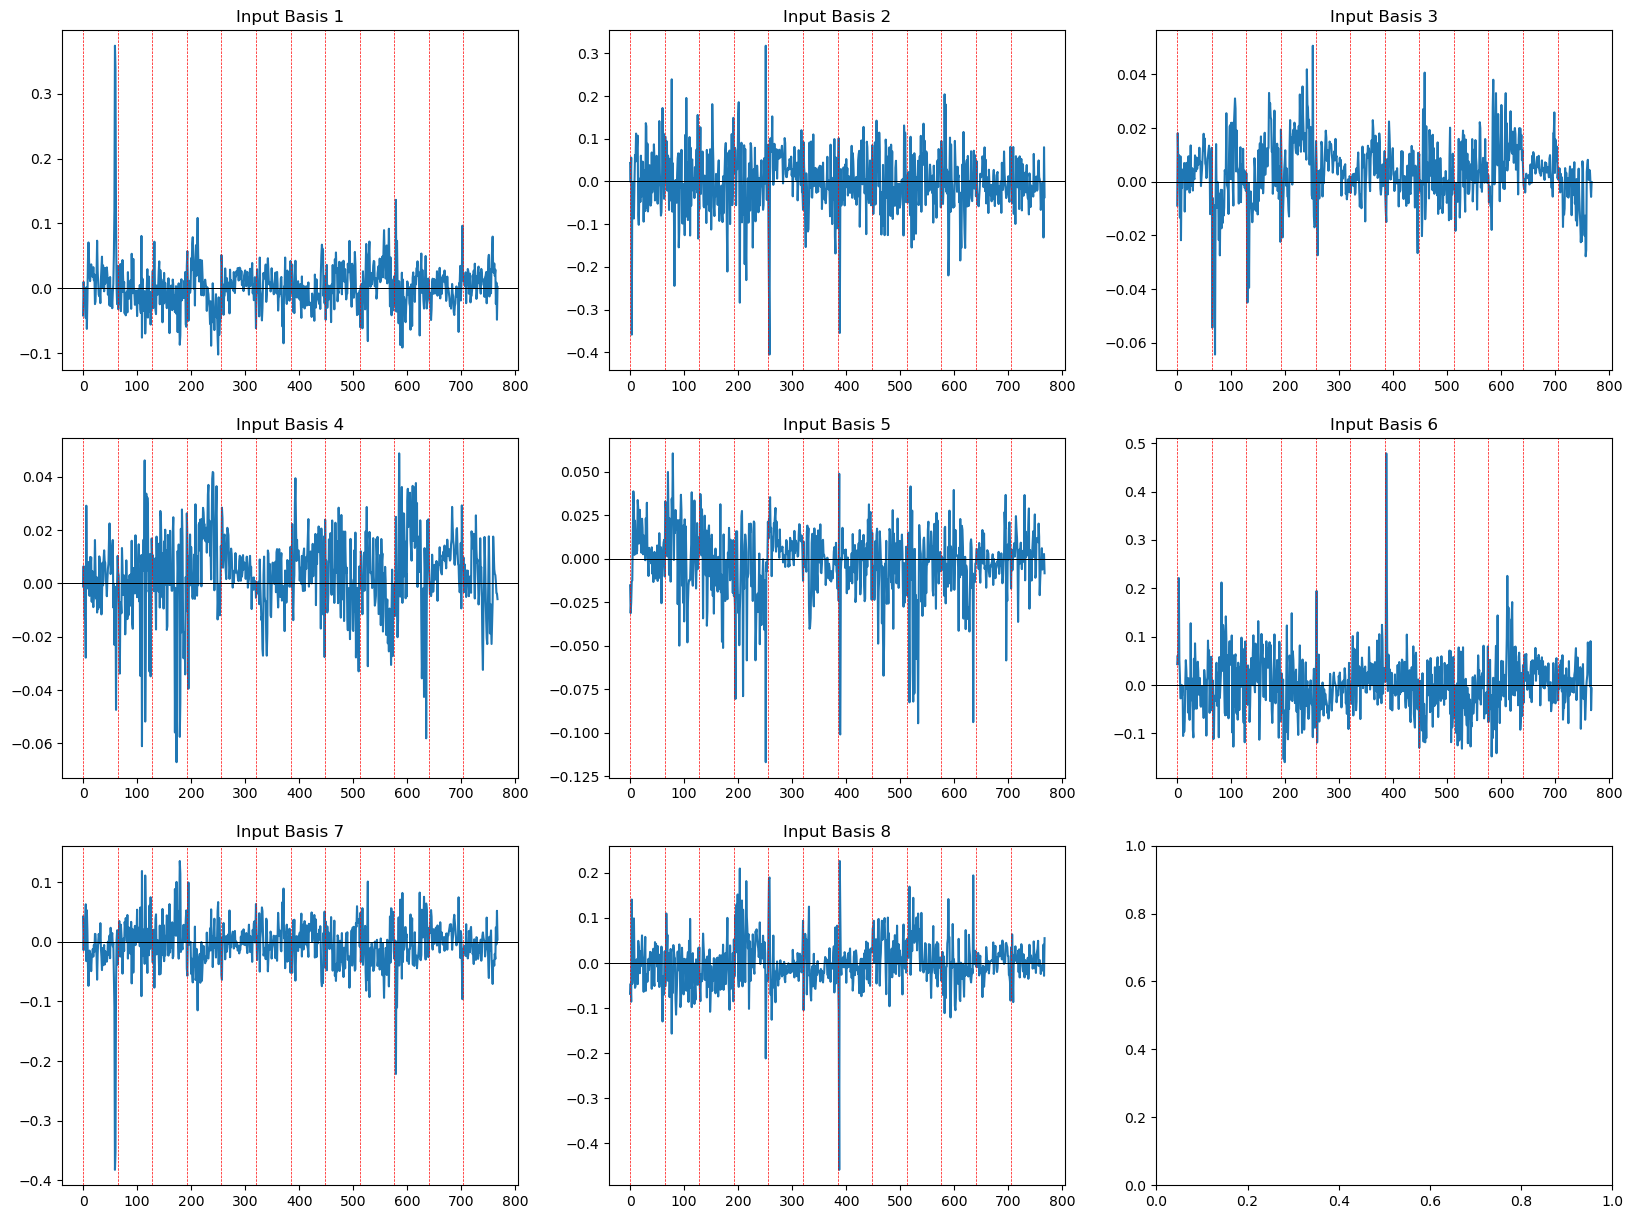

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for i in range(8):
    ax[i // 3][i % 3].plot(arrange_to_piece(input_basis[:, i].reshape(1, 768)).reshape(768))
    ax[i // 3][i % 3].set_title(f'Input Basis {i+1}')
    for k in range(0, 768, 64):
        ax[i//3][i%3].axvline(k, color='r', linestyle='--', linewidth=0.5)
        ax[i//3][i%3].axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.show()

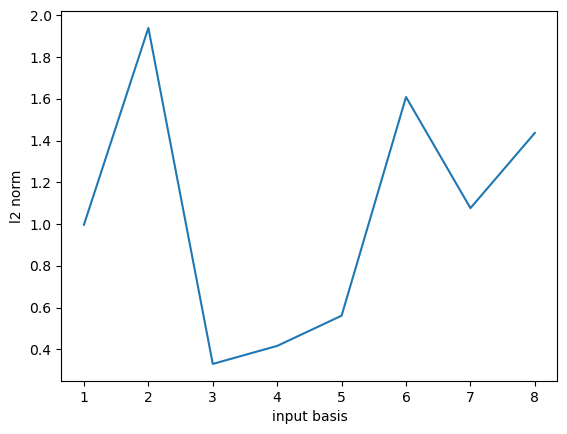

In [47]:
plt.plot(list(range(1, 9)), [torch.linalg.norm(input_basis[:, i]) for i in range(8)])
plt.xlabel('input basis')
plt.ylabel('l2 norm')
plt.show()

In [ ]:
for piece in PIECES.keys():
    heatmap_weight(get_piece_weight(input_basis.T, piece), piece)

In [ ]:
for k in range(8):
    fig, ax = plt.subplots(2, 6, figsize=(28, 8))
    i = 0
    for piece in PIECES.keys():
        w = input_basis.T[k,:].reshape(1,768)
        w = torch.reciprocal(w) # should we take reciprocal?
        vmax, vmin = torch.max(w), torch.min(w)
        sns.heatmap(get_piece_weight(w, piece).reshape(8,8), ax=ax[i // 6][i % 6], vmin=vmin, vmax=vmax)
        ax[i // 6][i % 6].set_title(f'Input Basis {k+1} for {PIECES_NAME[piece]}')
        i += 1
    plt.show()